In [1]:
import sys
sys.path.append("..")
from src.preprocess.data_prep_offenseval import DataPrepOffensEval
from src.classifiers.classifier_bi_lstm import BiLstmClassifier
from src.utils.stats import get_distribution_from_y
import pandas as pd

In [2]:
ENGLISH_FILE_PATH = "../data/raw/OffensEval2019/start-kit/training-v1/offenseval-training-v1.tsv"
def get_X_y():
    dp = DataPrepOffensEval()
    result_tuple = dp.get_X_and_ys(file_path=ENGLISH_FILE_PATH)
    X_original = result_tuple[0]
    y_sub_a = result_tuple[1]
    return X_original, y_sub_a

In [3]:
# Format our text samples and labels into tensors that can be fed into 
# a NN. To do this, we will rely on Keras utilities
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_NB_WORDS = 20000 # Max number of words in tweet to consider, ranked by frequency
MAX_SEQ_LENGTH = 1000 # Lengt of tensors that are fed into NN

def tokenize(X, max_nb_words=MAX_NB_WORDS, max_seq_length=MAX_SEQ_LENGTH):
    tokenizer = Tokenizer(num_words=max_nb_words)
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(X)
    word_index = tokenizer.word_index # Number of unique tokens
    X = pad_sequences(sequences, maxlen=max_seq_length) # PAD Everything to be the same length - necessary for keras
    return X, word_index

Using TensorFlow backend.


In [4]:
X, y = get_X_y()

In [5]:
X, word_index = tokenize(X)

In [6]:
dp = DataPrepOffensEval()
X_train, X_test, y_train, y_test = dp.train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = dp.train_test_split(X_train, y_train, test_size=0.1)

In [7]:
from gensim.models import KeyedVectors
NUM_VECTORS = 50000
ENGLISH_EMB_FILE_PATH = "../cc.en.300.vec"

en_model = KeyedVectors.load_word2vec_format(
    ENGLISH_EMB_FILE_PATH,
    limit=NUM_VECTORS,
)

In [8]:
import numpy as np

def create_embedding_matrix(model=en_model, X=X, embedding_dim=300, word_index=word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in model:
            embedding_vector = model[word]
            embedding_matrix[i] = embedding_vector
            # Words not found will be all zeros
    return embedding_matrix

In [9]:
embedding_matrix = create_embedding_matrix()

In [10]:
# Create the embedding layer from the embedding matrix for keras
from keras.layers import Embedding
EMBEDDING_DIM = 300

embedding_layer = Embedding(
    len(word_index) + 1,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQ_LENGTH,
    trainable=False,
)

In [11]:
from keras.layers import (
    Bidirectional, 
    Dropout, 
    Dense,
    Activation, 
    LSTM,
)

from keras import Sequential

def create_model(
    embedding_layer,
    dropout_amount=0.2,
    lstm_units=5,
    dense_1_units=4,
    dense_2_units=1,
    dense_1_activation="relu",
    dense_2_activation="sigmoid",
    optimizer="adam",
    loss_func="binary_crossentropy",
    metrics=["accuracy"],
):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(
        layer=LSTM(
            units=lstm_units,
            dropout=dropout_amount,
            recurrent_dropout=dropout_amount,
        )
    ))
    model.add(Dropout(dropout_amount))
    model.add(Dense(
        units=dense_1_units,
    ))
    model.add(Activation(dense_1_activation))
    model.add(Dropout(dropout_amount))
    model.add(Dense(
        units=dense_2_units,
    ))
    model.add(Activation(dense_2_activation))
    
    model.compile(
        optimizer=optimizer,
        loss=loss_func,
        metrics=metrics,
    )
    
    return model

# Early stopping when the model starts to overfit
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Patience is the nummber of epochs
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)

def train_model(
    model,
    X_train=X_train,
    y_train=y_train,
    epochs=20,
    batch_size=512,
    validation_data=[X_val,y_val],
):
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=2,
        callbacks=[es, mc],
    )
    return history

import matplotlib.pyplot as plt


def plot_train_val_loss(history):
    plt.clf()
    history_dict = history.history
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    
def plot_train_val_accuracy(history):
    plt.clf()
    history_dict = history.history
    train_metric = history_dict['acc']
    val_metric = history_dict['val_' + 'acc']
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, 'r', label='Training {}'.format('acc'))
    plt.plot(epochs, val_metric, 'b', label='Validation {}'.format('acc'))
    plt.title('Training and Validation {}'.format('acc'))
    plt.xlabel('Epochs')
    plt.ylabel('{}'.format('acc'))
    plt.legend()

    
def predict_y(model, X_test=X_test):
    y_pred = model.predict(X_test)
    y_pred_binary = [0 if value[0] < 0.5 else 1 for value in y_pred]
    return y_pred_binary


# Using this since we have the confusion matrix stuff implemented here
# Move that stuff into a unique module
from src.classifiers.classifier_bi_lstm import BiLstmClassifier


def plot_confusion_matrix(
    y_test,
    y_pred,
    num_categories=2,
    category_names=["NOT", "OFF"],
):
    classifier = BiLstmClassifier(
        embedding_input_dim=1,
        logfile=None,
        epochs=1,
    )
    confusion_df = classifier.confusion_matrix(
        y_test, y_pred, num_categories, category_names,
    )
    classifier.plot_confusion_matrix(
        confusion_df, file_path=None,
    )


In [12]:
model = create_model(embedding_layer)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
history = train_model(model)

Instructions for updating:
Use tf.cast instead.
Train on 10724 samples, validate on 1192 samples
Epoch 1/20
 - 101s - loss: 0.6934 - acc: 0.5597 - val_loss: 0.6903 - val_acc: 0.6418

Epoch 00001: val_loss improved from inf to 0.69028, saving model to best_model.h5
Epoch 2/20
 - 94s - loss: 0.6882 - acc: 0.6682 - val_loss: 0.6874 - val_acc: 0.6435

Epoch 00002: val_loss improved from 0.69028 to 0.68739, saving model to best_model.h5
Epoch 3/20
 - 95s - loss: 0.6848 - acc: 0.6706 - val_loss: 0.6846 - val_acc: 0.6443

Epoch 00003: val_loss improved from 0.68739 to 0.68459, saving model to best_model.h5
Epoch 4/20
 - 98s - loss: 0.6814 - acc: 0.6744 - val_loss: 0.6815 - val_acc: 0.6477

Epoch 00004: val_loss improved from 0.68459 to 0.68153, saving model to best_model.h5
Epoch 5/20
 - 99s - loss: 0.6779 - acc: 0.6792 - val_loss: 0.6781 - val_acc: 0.6611

Epoch 00005: val_loss improved from 0.68153 to 0.67811, saving model to best_model.h5
Epoch 6/20
 - 110s - loss: 0.6735 - acc: 0.6894 - v

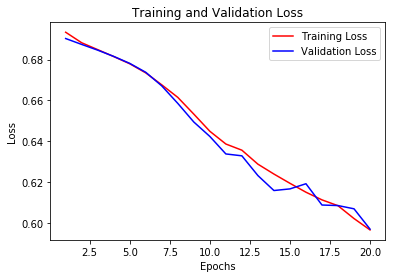

In [14]:
plot_train_val_loss(history)

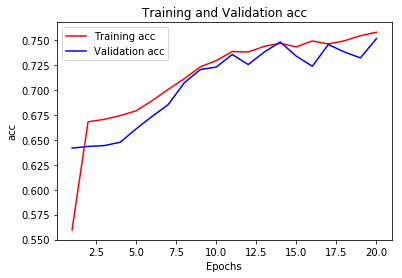

In [15]:
plot_train_val_accuracy(history)

In [16]:
y_pred = predict_y(model)

29/03/19 10:18:59 [INFO] Initialized Classifier: Bi-LSTM Based Model
29/03/19 10:18:59 [INFO] LSTM Layers: 50
29/03/19 10:18:59 [INFO] Embedding Input Dimension: 1
29/03/19 10:18:59 [INFO] Embedding Output Dimension: 100
29/03/19 10:18:59 [INFO] MLP Layers: 16
29/03/19 10:18:59 [INFO] MLP Activation: <function relu at 0x131964f28>
29/03/19 10:18:59 [INFO] Dropout 1: 0.5
29/03/19 10:18:59 [INFO] Dropout 2: 0.5
29/03/19 10:18:59 [INFO] Dropout 3: 0.5
29/03/19 10:18:59 [INFO] Output Activation: <function sigmoid at 0x1319e7510>
29/03/19 10:18:59 [INFO] Epochs: 1
29/03/19 10:18:59 [INFO] Batch Size: 512
29/03/19 10:18:59 [INFO] Optimizer: adam
29/03/19 10:18:59 [INFO] Loss Function: binary_crossentropy
29/03/19 10:18:59 [INFO] Metrics: ['accuracy']


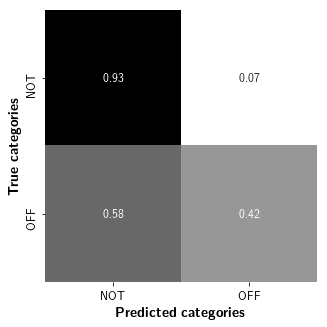

In [17]:
plot_confusion_matrix(y_test, y_pred)

# Test out oversampling
[Based on this article](https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a)

In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [20]:
print(X_sm.shape, y_sm.shape)

(14340, 1000) (14340,)


In [21]:
model_over_sampl = create_model(embedding_layer=embedding_layer)
history_over_sampl = train_model(X_train=X_sm, y_train=y_sm, model=model_over_sampl)

Train on 14340 samples, validate on 1192 samples
Epoch 1/20
 - 130s - loss: 0.6913 - acc: 0.5239 - val_loss: 0.6890 - val_acc: 0.5227

Epoch 00001: val_loss did not improve from 0.59695
Epoch 2/20
 - 129s - loss: 0.6801 - acc: 0.5715 - val_loss: 0.6733 - val_acc: 0.5847

Epoch 00002: val_loss did not improve from 0.59695
Epoch 3/20
 - 125s - loss: 0.6610 - acc: 0.6051 - val_loss: 0.6620 - val_acc: 0.6149

Epoch 00003: val_loss did not improve from 0.59695
Epoch 4/20
 - 127s - loss: 0.6536 - acc: 0.6056 - val_loss: 0.6446 - val_acc: 0.6326

Epoch 00004: val_loss did not improve from 0.59695
Epoch 5/20
 - 119s - loss: 0.6474 - acc: 0.6188 - val_loss: 0.6399 - val_acc: 0.6544

Epoch 00005: val_loss did not improve from 0.59695
Epoch 6/20
 - 117s - loss: 0.6408 - acc: 0.6234 - val_loss: 0.6409 - val_acc: 0.6602

Epoch 00006: val_loss did not improve from 0.59695
Epoch 7/20
 - 117s - loss: 0.6345 - acc: 0.6453 - val_loss: 0.6312 - val_acc: 0.6720

Epoch 00007: val_loss did not improve from 

In [1]:
plot_train_val_loss(history)

NameError: name 'plot_train_val_loss' is not defined

In [ ]:
plot_train_val_accuracy(history)

In [ ]:
y_pred = predict_y(model)

In [ ]:
plot_confusion_matrix(y_test, y_pred)